In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rotten-tomatoes-reviews/rt_reviews.csv


Read the data

In [7]:
news_data=pd.read_csv('/kaggle/input/rotten-tomatoes-reviews/rt_reviews.csv',encoding='latin-1');
news_data.head()

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


In [8]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Freshness  480000 non-null  object
 1   Review     480000 non-null  object
dtypes: object(2)
memory usage: 7.3+ MB


### Concat "headline" and "short_description" and add a new column

In [9]:
/#news_data["Content"] = news_data["headline"] + " " + news_data["short_description"]

### All words to lower case to remove duplicates
news_data["Review"] = news_data["Review"].str.lower()
### Removing all punctuations
import string
news_data["Review"] = news_data["Review"].str.replace(f"[{string.punctuation}]", "", regex=True)

### Removing unnecessary spaces
news_data["Review"] = news_data["Review"].str.replace("(^\s+|\s+$)", "", regex=True)
news_data["Review"] = news_data["Review"].str.replace("\s+", " ", regex=True)


news_data["Review"][0]

'manakamana doesnt answer any questions yet makes its point nepal like the rest of our planet is a picturesque but far from peaceable kingdom'

### Split data into Train,Validate and Test

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(news_data, test_size=0.3, random_state=42)
print("Train ", len(train.index))
print("Test ", len(test.index))

Train  336000
Test  144000


In [11]:
test, validate = train_test_split(test, test_size=0.5, random_state=42)
print("Test ", len(test.index))
print("validate ", len(validate.index))

Test  72000
validate  72000


### Calculate Prior Probability for Categories

In [13]:
category_counts = train["Freshness"].value_counts()
category_counts_sum = np.sum(category_counts)

### Calculating the Prior Probability for Categories
pr_category_prior = pd.DataFrame(category_counts).T
pr_category_prior = pr_category_prior/category_counts_sum
pr_category_prior

,fresh,rotten
Freshness,0.500009,0.499991


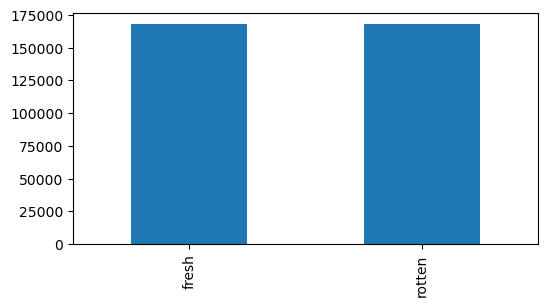

In [15]:
plt.figure(figsize=(6,3))
category_counts.plot(kind='bar');

### Build a list of vocabulary

In [9]:
### TO-DO: Remove STOP WORDS, i.e. words with very high occurance
###        or the words commonly used in all categories

In [21]:
from tqdm import tqdm
from collections import Counter

def get_word_frequency(pd_df, 
                       vocab_list = None, 
                       category="all", 
                       min_word_occur = 5, 
                      ):
    """
    pd_df: [Required] Input dataframe
    vocab_list: [Optional] [Required when category='all'] 
                List of words to calculate the frequency for
    category: Default is for all categories
    min_word_occur: Default is 5
    """
    ### Selecting sentence of the category
    if category!="all":
        pd_df = pd_df[pd_df["Freshness"]==category]
    
    if vocab_list is None and category=="all":
        pass
    elif vocab_list is None:
        Exception("Please provide vocab_list to continue!")
    
    ### Creating the vocabulary
    print("Creating the vocabulary...")
    vocab_all = []
    for sentence in tqdm(pd_df["Review"]):
        vocab_all.append(sentence.split())
    vocab_all = np.concatenate(vocab_all).flatten()
    print("Total words in the sentences:", len(vocab_all))
    
    ### Counting the words
    Vocab_Dict = Counter(vocab_all)
    if category=="all":
        ### Limiting to words with frequency >= 5
        Vocab_Dict = {k:v for k, v in Vocab_Dict.items() if Vocab_Dict[k] >= 5}
    else:
        ### Limiting to words from the given vocab_list
        Vocab_Dict = {k:v for k, v in Vocab_Dict.items() if k in vocab_list}
    vocab = list(Vocab_Dict.keys())
    print("Length of Vocab:", len(vocab))
    
    return Vocab_Dict, vocab

In [22]:
def get_word_frequency1(pd_df, 
                       vocab_list = None, 
                       category="all", 
                       min_word_occur = 5, 
                      ):
    """
    pd_df: [Required] Input dataframe
    vocab_list: [Optional] [Required when category='all'] 
                List of words to calculate the frequency for
    category: Default is for all categories
    min_word_occur: Default is 5
    """
    ### Selecting sentence of the category
    if category!="all":
        pd_df = pd_df[pd_df["Freshness"]==category]
    
    if vocab_list is None and category=="all":
        pass
    elif vocab_list is None:
        Exception("Please provide vocab_list to continue!")
    
    ### Creating the vocabulary
    vocab_all = []
    for sentence in tqdm(pd_df["Review"]):
        vocab_all.append(sentence.split())
    vocab_all = np.concatenate(vocab_all).flatten()
    
    ### Counting the words
    Vocab_Dict = Counter(vocab_all)
    if category=="all":
        ### Limiting to words with frequency >= 5
        Vocab_Dict = {k:v for k, v in Vocab_Dict.items() if Vocab_Dict[k] >= 5}
    else:
        ### Limiting to words from the given vocab_list
        Vocab_Dict = {k:v for k, v in Vocab_Dict.items() if k in vocab_list}
    vocab = list(Vocab_Dict.keys())
    
    return Vocab_Dict, vocab

In [23]:
Vocab_Dict, vocab = get_word_frequency(train)

Creating the vocabulary...


100%|██████████| 336000/336000 [00:02<00:00, 158610.84it/s]


Total words in the sentences: 7285822
Length of Vocab: 39036


In [24]:
print(list(Vocab_Dict.items())[:5])
print(vocab[:5])

[('does', 7488), ('one', 26317), ('really', 6837), ('have', 21878), ('to', 159157)]
['does', 'one', 'really', 'have', 'to']


In [25]:
word_freq_df = pd.DataFrame(vocab, columns=["vocab"])
word_freq_df.head()

,vocab
0,does
1,one
2,really
3,have
4,to


### Building a word frequency dataframe on train data for each class

In [26]:
for category in category_counts.index:
    print("====================")
    print(f"Computing counts for {category} Freshness.")
    catg_vocab_dict, _ = get_word_frequency(train, 
                                            vocab_list = vocab, 
                                            category=category, 
                                           )
    catg_vocab_df = pd.DataFrame(catg_vocab_dict.items(), columns=["vocab", category])
    word_freq_df = word_freq_df.merge(catg_vocab_df, on="vocab", how="left")
    # ### Filling null values with 0s
    # word_freq_df[category] = word_freq_df[category].fillna(0).astype(int)

Computing counts for fresh Freshness.
Creating the vocabulary...


100%|██████████| 168003/168003 [00:01<00:00, 160403.32it/s]


Total words in the sentences: 3682549
Length of Vocab: 37601
Computing counts for rotten Freshness.
Creating the vocabulary...


100%|██████████| 167997/167997 [00:00<00:00, 214339.20it/s]


Total words in the sentences: 3603273
Length of Vocab: 37619


In [27]:
word_freq_df.head()

,vocab,fresh,rotten
0,does,4000.0,3488.0
1,one,14406.0,11911.0
2,really,2701.0,4136.0
3,have,8996.0,12882.0
4,to,73877.0,85280.0


In [28]:
### Calculating the P(w|c), i.e. probability of word given a category
smoothing = True
if smoothing:
    pr_word_c_category = word_freq_df.set_index("vocab").fillna(0) + 1
else:
    pr_word_c_category = word_freq_df.set_index("vocab")
pr_word_c_category = pr_word_c_category.div(pr_word_c_category.sum(axis=0), axis=1)
pr_word_c_category

,fresh,rotten
vocab,,
does,1.094319e-03,9.751846e-04
one,3.940478e-03,3.329435e-03
really,7.390277e-04,1.156302e-03
have,2.460782e-03,3.600832e-03
to,2.020647e-02,2.383626e-02
...,...,...
admissions,8.205341e-07,1.118010e-06
corrects,5.470228e-07,1.397513e-06
scenetoscene,8.205341e-07,1.118010e-06


### Validate

Five Fold Cross Validation

In [29]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

fold_length=int(len(train)/5)
print(fold_length)
for i in range(5):
    if i==0:
        curr_fold_validate=train[0:fold_length]
        curr_fold_train=train[~train.isin(curr_fold_validate)].dropna()
        
    else:
        curr_fold_validate=train[i*fold_length:(i+1)*fold_length]
        curr_fold_train=train[~train.isin(curr_fold_validate)].dropna()
        print(len(curr_fold_train))
    category_counts = curr_fold_train["Freshness"].value_counts()
    category_counts_sum = np.sum(category_counts)
    
    ### Calculating the Prior Probability for Categories
    pr_category_prior = pd.DataFrame(category_counts).T
    pr_category_prior = pr_category_prior/category_counts_sum
    pr_category_prior
    Vocab_Dict, vocab = get_word_frequency(curr_fold_train)
    word_freq_df = pd.DataFrame(vocab, columns=["vocab"])
    for category in category_counts.index:
        catg_vocab_dict, _ = get_word_frequency1(curr_fold_train, 
                                                vocab_list = vocab, 
                                                category=category, 
                                               )
        catg_vocab_df = pd.DataFrame(catg_vocab_dict.items(), columns=["vocab", category])
        word_freq_df = word_freq_df.merge(catg_vocab_df, on="vocab", how="left")
    smoothing = True
    if smoothing:
        pr_word_c_category = word_freq_df.set_index("vocab").fillna(0) + 1
    else:
        pr_word_c_category = word_freq_df.set_index("vocab")
    pr_word_c_category = pr_word_c_category.div(pr_word_c_category.sum(axis=0), axis=1)
    
    Fold_category_predicted = []
    for sentence in tqdm(curr_fold_validate["Review"]):
        valid_words = [word for word in sentence.split() if word in vocab]
        valid_words_df = pd.DataFrame(valid_words, columns=["vocab"])
        valid_words_df = valid_words_df.merge(pr_word_c_category, on="vocab", how="inner").set_index("vocab")
        valid_pr_word_c_category = pd.DataFrame(valid_words_df.prod(axis=0), columns=["prob"])
        valid_pr_numer = valid_pr_word_c_category.join(pr_category_prior.T)
        valid_pr_numer["final_prob"] = valid_pr_numer["prob"] * valid_pr_numer["Freshness"]
        Fold_category_predicted.append(valid_pr_numer["final_prob"].idxmax())
    accu=accuracy_score(curr_fold_validate["Freshness"], Fold_category_predicted)
    print("Fold",i+1,", accuracy=",accu)

67200
Creating the vocabulary...


100%|██████████| 268800/268800 [00:01<00:00, 160420.58it/s]


Total words in the sentences: 5831045
Length of Vocab: 35105


100%|██████████| 67200/67200 [21:36<00:00, 51.81it/s]


Fold 1 , accuracy= 0.7956845238095238
268800
Creating the vocabulary...


100%|██████████| 268800/268800 [00:01<00:00, 160586.05it/s]


Total words in the sentences: 5827372
Length of Vocab: 35102


100%|██████████| 67200/67200 [23:50<00:00, 46.97it/s]


Fold 2 , accuracy= 0.7964285714285714
268800
Creating the vocabulary...


100%|██████████| 268800/268800 [00:01<00:00, 188700.60it/s]


Total words in the sentences: 5829747
Length of Vocab: 35108


100%|██████████| 67200/67200 [23:04<00:00, 48.54it/s]


Fold 3 , accuracy= 0.7943154761904762
268800
Creating the vocabulary...


100%|██████████| 268800/268800 [00:01<00:00, 135560.42it/s]


Total words in the sentences: 5827434
Length of Vocab: 35156


100%|██████████| 67200/67200 [22:30<00:00, 49.75it/s]


Fold 4 , accuracy= 0.7988690476190476
268800
Creating the vocabulary...


100%|██████████| 268800/268800 [00:01<00:00, 176029.41it/s]


Total words in the sentences: 5827690
Length of Vocab: 35179


100%|██████████| 67200/67200 [23:28<00:00, 47.72it/s]


Fold 5 , accuracy= 0.7966071428571428


In [30]:
validate.head()

,Freshness,Review
373046,fresh,if this film were a person youd want to give i...
452330,rotten,a soap opera for people who dont watch soap op...
3140,fresh,bounding onto screens with a heart far bigger ...
69269,rotten,haifaa almonsour loses out by attempting to wa...
289431,fresh,a revenge movie of demolishing beauty and sust...


In [31]:
valid_category_predicted = []
for sentence in tqdm(validate["Review"]):
    valid_words = [word for word in sentence.split() if word in vocab]
    valid_words_df = pd.DataFrame(valid_words, columns=["vocab"])
    valid_words_df = valid_words_df.merge(pr_word_c_category, on="vocab", how="inner").set_index("vocab")
    valid_pr_word_c_category = pd.DataFrame(valid_words_df.prod(axis=0), columns=["prob"])
    valid_pr_numer = valid_pr_word_c_category.join(pr_category_prior.T)
    valid_pr_numer["final_prob"] = valid_pr_numer["prob"] * valid_pr_numer["Freshness"]
    valid_category_predicted.append(valid_pr_numer["final_prob"].idxmax())

100%|██████████| 72000/72000 [25:11<00:00, 47.62it/s]


In [32]:
print(classification_report(valid_category_predicted, validate["Freshness"]))

              precision    recall  f1-score   support

       fresh       0.78      0.81      0.79     34579
      rotten       0.82      0.79      0.80     37421

    accuracy                           0.80     72000
   macro avg       0.80      0.80      0.80     72000
weighted avg       0.80      0.80      0.80     72000



In [34]:
confusion_matrix(valid_category_predicted, validate["Freshness"])

array([[28021,  6558],
       [ 8010, 29411]])

<AxesSubplot:>

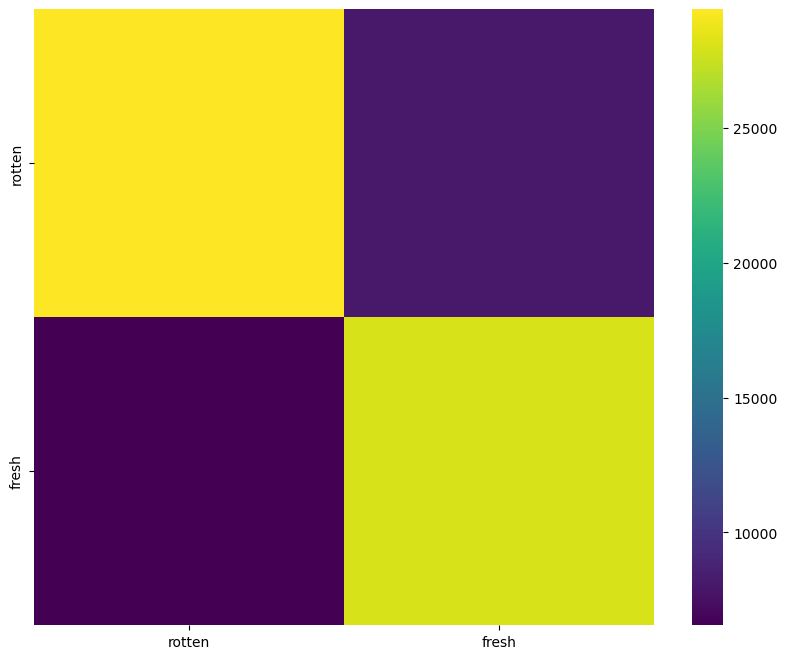

In [36]:
conf_matrix = confusion_matrix(valid_category_predicted, validate["Freshness"], labels=category_counts.index)

import seaborn as sns
plt.figure(figsize = (10,8))
sns.heatmap(pd.DataFrame(conf_matrix, 
                         index=category_counts.index, 
                         columns=category_counts.index), 
            cmap="viridis")

<AxesSubplot:>

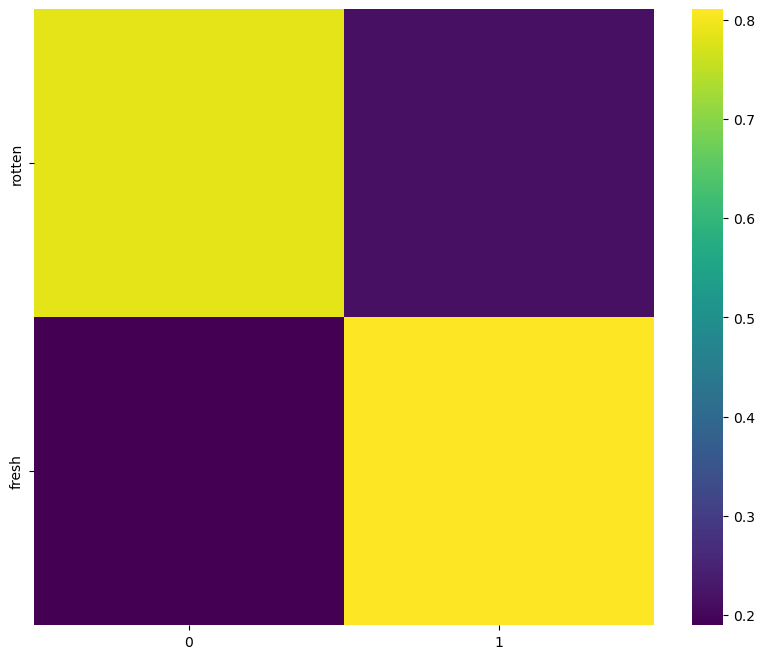

In [37]:
conf_mat_df = pd.DataFrame(conf_matrix, index=category_counts.index)
conf_mat_df = conf_mat_df.div(conf_mat_df.sum(axis=1), axis=0)

plt.figure(figsize = (10,8))
sns.heatmap(conf_mat_df, cmap="viridis")

In [38]:
accuracy_score(validate["Freshness"], valid_category_predicted)

0.7976666666666666

Finding accuracy on test data

In [40]:
test_category_predicted = []
for sentence in tqdm(test["Review"]):
    valid_words = [word for word in sentence.split() if word in vocab]
    valid_words_df = pd.DataFrame(valid_words, columns=["vocab"])
    valid_words_df = valid_words_df.merge(pr_word_c_category, on="vocab", how="inner").set_index("vocab")
    valid_pr_word_c_category = pd.DataFrame(valid_words_df.prod(axis=0), columns=["prob"])
    valid_pr_numer = valid_pr_word_c_category.join(pr_category_prior.T)
    valid_pr_numer["final_prob"] = valid_pr_numer["prob"] * valid_pr_numer["Freshness"]
    test_category_predicted.append(valid_pr_numer["final_prob"].idxmax())
    

100%|██████████| 72000/72000 [25:02<00:00, 47.91it/s]


In [42]:
accuracy_score(test["Freshness"], test_category_predicted)

0.7966388888888889